In [47]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plts
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from AngioMorphPCA.cut_centerline import read_vtk_curve, cut_curve, interpolate_curve, write_vtk_curve


# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.rcParams['image.cmap'] = 'jet'  # 替换为你想要的 colormap 名称


def interpolate_to_fixed_points(sorted_curve_bs, target_points=120):
    """
    将 (n, m, 3) 形状的 3D 曲线数据插值为 (n, target_points, 3) 形状的数据。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    target_points (int): 插值后的目标点数，默认值为 120。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 119, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 120, 3)
    
    for i in range(n):
        for j in range(d):  # 对每个维度 (x, y, z) 单独进行插值
            original_points = sorted_curve_bs[i, :, j]
            original_indices = np.linspace(0, 1, m)  # 原始曲线的归一化位置
            target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
            interpolator = interp1d(original_indices, original_points, kind='linear')
            interpolated_data[i, :, j] = interpolator(target_indices)  # 在目标点上插值
    
    return interpolated_data

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)


    
    # 计算每个差值的欧氏距离，并求和

    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))

    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

def resample_standardized_curves(standardized_centerlines, standardized_abscissas, m):
    """
    Resample each curve in standardized_centerlines to have exactly m points.

    :param standardized_centerlines: List of (n,3) numpy arrays representing 3D curves.
    :param standardized_abscissas: List of (n,) numpy arrays representing abscissas corresponding to each curve.
    :param m: The number of points each resampled curve should have.
    :return: (new_centerlines, new_abscissas), both resampled to m points.
    """
    new_centerlines = []
    new_abscissas = []

    for i in range(len(standardized_centerlines)):
        curve = standardized_centerlines[i]  # (n,3)
        abscissas = standardized_abscissas[i]  # (n,)

        # 生成新的m个等间距 abscissas
        new_t = np.linspace(abscissas[0], abscissas[-1], m)

        # 分别对 x, y, z 进行插值
        interp_x = interp1d(abscissas, curve[:, 0], kind='cubic', fill_value="extrapolate")
        interp_y = interp1d(abscissas, curve[:, 1], kind='cubic', fill_value="extrapolate")
        interp_z = interp1d(abscissas, curve[:, 2], kind='cubic', fill_value="extrapolate")

        # 计算新的坐标
        new_x = interp_x(new_t)
        new_y = interp_y(new_t)
        new_z = interp_z(new_t)

        # 组合 x, y, z
        new_curve = np.vstack((new_x, new_y, new_z)).T  # (m, 3)

        # 存储结果
        new_centerlines.append(new_curve)
        new_abscissas.append(new_t)

    return new_centerlines, new_abscissas


def align_centerlines_procrustes(original_centerlines):
    num_curves, num_points, dim = original_centerlines.shape
    
    # 选择第一条曲线作为参考
    reference_curve = original_centerlines[0]

    aligned_centerlines = np.zeros_like(original_centerlines)

    for i in range(num_curves):
        _, aligned_curve, _ = procrustes(reference_curve, original_centerlines[i])
        aligned_centerlines[i] = aligned_curve

    return aligned_centerlines


curve_bs = np.load("../geom_aligned_curves_88/geomstats_aligned_to_first_88.npy")
curve_cs = np.load("../geom_aligned_curves_88/geomstats_aligned_to_first_88.npy")
# curve_bs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")
# curve_cs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")


curve_bs = interpolate_to_fixed_points(curve_bs, 120)
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_88/total_files_88.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)

original_centerlines = []
abscissas = []
original_lengths = []
curve_ds = [] # curve_ds是用original_length还原长度的curve_bs,好像难以解释它是怎么求得的
standardized_centerlines = []
standardized_abscissas = []
original_tortuosities = []
original_norms = []

m=75
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    # print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_lengths.append(calculate_curve_length(original_centerline))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))
    curve_ds.append(curve_bs[i] * calculate_curve_length(original_centerline))
    original_tortuosities.append(calculate_curve_length(original_centerline)/np.linalg.norm(original_centerline[-1]-original_centerline[0]))
    original_norms.append(np.linalg.norm(original_centerline[-1]-original_centerline[0]))
print ("所有中心线的original长度的均值是",np.mean(original_lengths), "标准差是", np.std(original_lengths))

for i in range(len(files)):
    standardized_centerlines.append(original_centerlines[i]*np.mean(original_lengths)/original_lengths[i])
    standardized_abscissas.append(abscissas[i]*np.mean(original_lengths)/original_lengths[i])

resampled_standardized_centerlines, resampled_standardized_abscissas = resample_standardized_curves(standardized_centerlines, standardized_abscissas, m)

original_norms = np.array(original_norms)
original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)
original_lengths = np.array(original_lengths)
original_tortuosities = np.array(original_tortuosities)
curve_ds = np.array(curve_ds)
resampled_standardized_centerlines = np.array(resampled_standardized_centerlines)
resampled_standardized_abscissas = np.array(resampled_standardized_abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

# print (files_label)

original_centerlines_copy = np.copy(original_centerlines)
resampled_standardized_centerlines_copy = np.copy(resampled_standardized_centerlines)




curve_bs.shape: (88, 120, 3)
files length: 88
所有中心线的original长度的均值是 74.93372771687922 标准差是 8.185160960582923


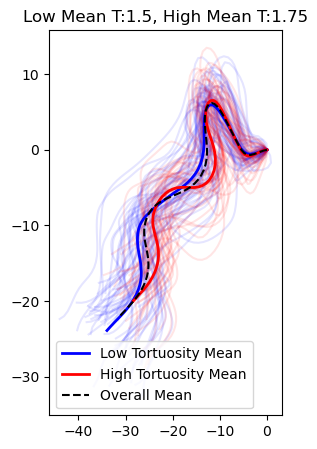

In [48]:
low_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities < 1.8]
high_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities > 1.8]

low_tortuosity_standardized_mean = np.mean(low_tortuosity_standardized_centerlines, axis=0)
high_tortuosity_standardized_mean = np.mean(high_tortuosity_standardized_centerlines, axis=0)

low_t_standardized_mean_tortuosity = calculate_curve_length(low_tortuosity_standardized_mean)/np.linalg.norm(low_tortuosity_standardized_mean[-1]-low_tortuosity_standardized_mean[0])
high_t_standardized_mean_tortuosity = calculate_curve_length(high_tortuosity_standardized_mean)/np.linalg.norm(high_tortuosity_standardized_mean[-1]-high_tortuosity_standardized_mean[0])

# 分别画出两类曲线
plt.figure(figsize=(3,5),dpi=100)

for curve in low_tortuosity_standardized_centerlines:
    plt.plot(curve[:, 1], -curve[:, 2], c='b', alpha=0.1)
for curve in high_tortuosity_standardized_centerlines:
    plt.plot(curve[:, 1], -curve[:, 2], c='r', alpha=0.1)

plt.plot(low_tortuosity_standardized_mean[:, 1], -low_tortuosity_standardized_mean[:, 2], c='b', label="Low Tortuosity Mean",linewidth=2)
plt.plot(high_tortuosity_standardized_mean[:, 1], -high_tortuosity_standardized_mean[:, 2], c='r', label="High Tortuosity Mean",linewidth=2)
plt.plot(np.mean(resampled_standardized_centerlines, axis=0)[:, 1], 
         -np.mean(resampled_standardized_centerlines, axis=0)[:, 2], 
         c='k', 
         label="Overall Mean",
         linestyle='--')
plt.title("Low Mean T:{}, High Mean T:{}".format(round(low_t_standardized_mean_tortuosity,2), round(high_t_standardized_mean_tortuosity,2)))
plt.legend()
plt.show()


mean_estimate_tortuosity: 1.5848965786849918
mean_estimate.shape: (120, 3)
curve_bs.shape: (88, 120, 3)


<Figure size 600x200 with 0 Axes>

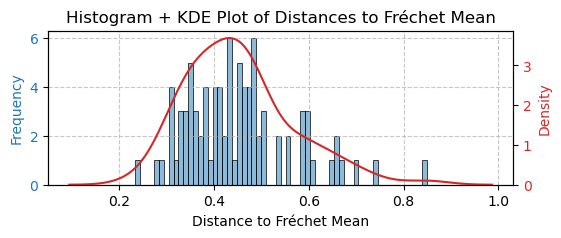

<Figure size 600x200 with 0 Axes>

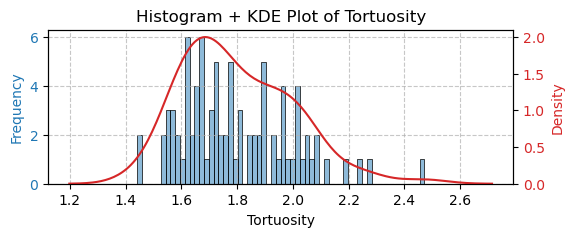

<Figure size 600x200 with 0 Axes>

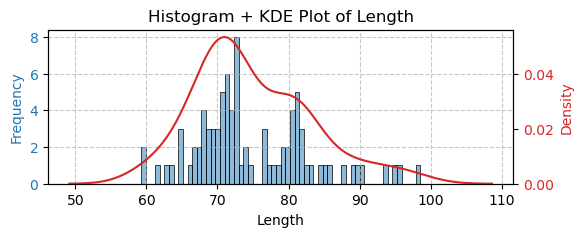

<Figure size 600x200 with 0 Axes>

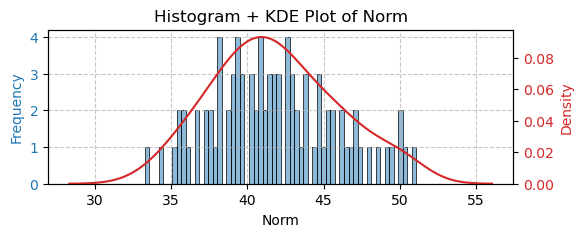

In [49]:
k_sampling_points = 121

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()
mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_

mean_estimate_tortuosity = calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0])
print ("mean_estimate_tortuosity:", mean_estimate_tortuosity)


print ("mean_estimate.shape:", mean_estimate.shape) # mean_estimate.shape: (120, 3)
print ("curve_bs.shape:", curve_cs.shape) # curve_bs.shape: (79, 120, 3)
g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)


bins = 60
plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

# 直方图（频数）
sns.histplot(g_dist_to_frechet, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Distance to Fréchet Mean")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# KDE曲线（密度）- 第二个y轴
ax2 = ax1.twinx()
sns.kdeplot(g_dist_to_frechet, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Distances to Fréchet Mean")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_tortuosities, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Tortuosity")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_tortuosities, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Tortuosity")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_lengths, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Length")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_lengths, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Length")
plt.show()


plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_norms, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Norm")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_norms, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Norm")
plt.show()



=======GMM========


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Length BIC: 632.5775290765918
Tortuosity BIC: -24.368782552702385


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


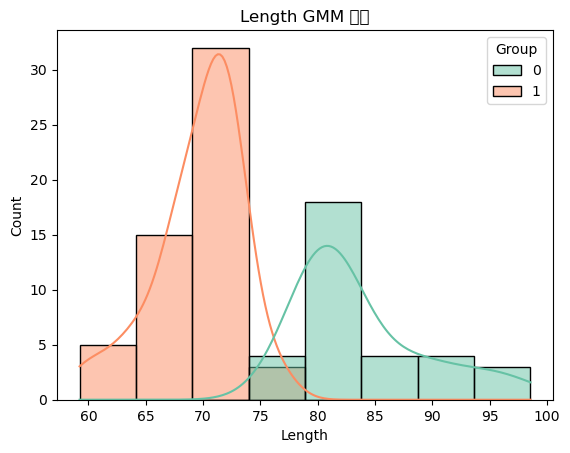

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


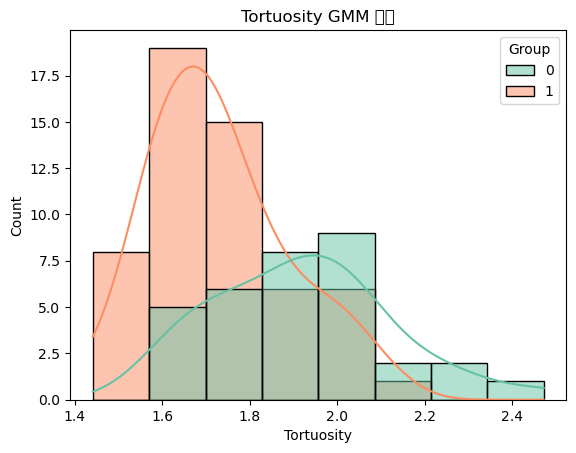

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


=======GMM========
Low Length Group Norm Mean: 43.95738007662347
High Length Group Norm Mean: 40.53090263319371
T-test: t = 4.007, p = 0.000


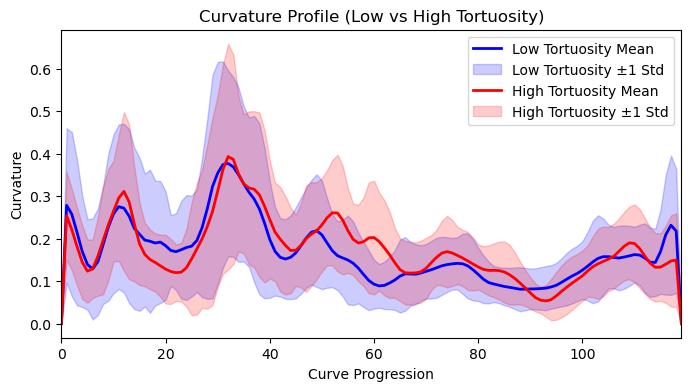

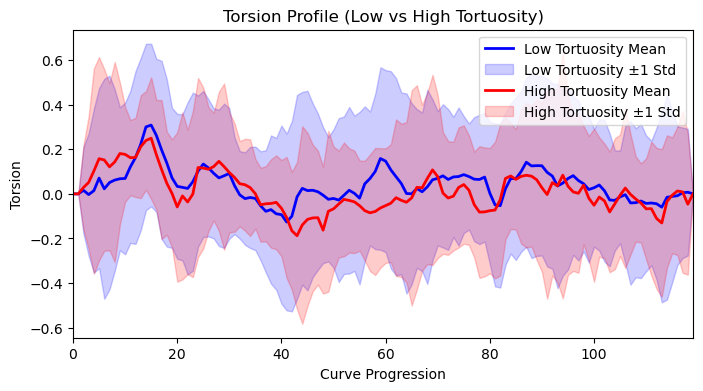

In [50]:
print ("=======GMM========")
from sklearn.mixture import GaussianMixture

# Length 双峰验证
gmm_length = GaussianMixture(n_components=2, random_state=0)
gmm_length.fit(original_lengths.reshape(-1, 1))
length_labels = gmm_length.predict(original_lengths.reshape(-1, 1))

# Tortuosity 双峰验证
gmm_tortuosity = GaussianMixture(n_components=2, random_state=0)
gmm_tortuosity.fit(original_tortuosities.reshape(-1, 1))
tortuosity_labels = gmm_tortuosity.predict(original_tortuosities.reshape(-1, 1))

print("Length BIC:", gmm_length.bic(original_lengths.reshape(-1, 1)))
print("Tortuosity BIC:", gmm_tortuosity.bic(original_tortuosities.reshape(-1, 1)))


df = pd.DataFrame({
    'Length': original_lengths,
    'Group': length_labels
})
df['Tortuosity'] = original_tortuosities

sns.histplot(data=df, x='Length', kde=True, hue='Group', palette='Set2')
plt.title("Length GMM 分组")
plt.show()

sns.histplot(data=df, x='Tortuosity', kde=True, hue='Group', palette='Set2')
plt.title("Tortuosity GMM 分组")
plt.show()


print ("=======GMM========")


low_group_norms = original_norms[length_labels == 0]
high_group_norms = original_norms[length_labels == 1]

print("Low Length Group Norm Mean:", np.mean(low_group_norms))
print("High Length Group Norm Mean:", np.mean(high_group_norms))

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(low_group_norms, high_group_norms, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3f}")




# 因为1.8似乎是hist上的一个坑
low_c = []
high_c = []
low_t = []
high_t = []

for i in range(len(original_centerlines_copy)):
    c,t = compute_curvature_and_torsion(original_centerlines_copy[i])
    if i in indices:
        high_c.append(c)
        high_t.append(t)
    else:
        low_c.append(c)
        low_t.append(t)

# 假设low_c 和 high_c 已经计算完成，形状均为 (n_curves, n_points_per_curve)
low_c = np.array(low_c)
high_c = np.array(high_c)
low_t = np.array(low_t)
high_t = np.array(high_t)

# 计算每类曲线的均值和标准差
low_c_mean = np.mean(low_c, axis=0)
low_c_std = np.std(low_c, axis=0)
low_t_mean = np.mean(low_t, axis=0)
low_t_std = np.std(low_t, axis=0)

high_c_mean = np.mean(high_c, axis=0)
high_c_std = np.std(high_c, axis=0)
high_t_mean = np.mean(high_t, axis=0)
high_t_std = np.std(high_t, axis=0)

# 绘图
plt.figure(figsize=(8, 4))

# 绘制 Low Tortuosity
plt.plot(low_c_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(low_c_mean)),
                 low_c_mean - low_c_std,
                 low_c_mean + low_c_std,
                 color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# 绘制 High Tortuosity
plt.plot(high_c_mean, color='r', label='High Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(high_c_mean)),
                 high_c_mean - high_c_std,
                 high_c_mean + high_c_std,
                 color='r', alpha=0.2, label='High Tortuosity ±1 Std')

plt.xlabel("Curve Progression")
plt.ylabel("Curvature")
plt.title("Curvature Profile (Low vs High Tortuosity)")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

# 绘图
plt.figure(figsize=(8, 4))

# 绘制 Low Tortuosity
plt.plot(low_t_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(low_t_mean)),
                 low_t_mean - low_t_std,
                 low_t_mean + low_t_std,
                 color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# 绘制 High Tortuosity
plt.plot(high_t_mean, color='r', label='High Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(high_t_mean)),
                 high_t_mean - high_t_std,
                 high_t_mean + high_t_std,
                 color='r', alpha=0.2, label='High Tortuosity ±1 Std')

plt.xlabel("Curve Progression")
plt.ylabel("Torsion")
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Torsion Profile (Low vs High Tortuosity)")
plt.legend()
plt.show()


In [51]:
from sklearn.mixture import GaussianMixture
import numpy as np

# GMM拟合Tortuosity的双峰分布
gmm_tortuosity = GaussianMixture(n_components=2, random_state=0)
gmm_tortuosity.fit(original_tortuosities.reshape(-1, 1))

# 每条曲线属于哪个类别 (0 或 1)
tortuosity_labels = gmm_tortuosity.predict(original_tortuosities.reshape(-1, 1))

# 也可以得到属于每个类的概率，部分数据可能是“边缘情况”
tortuosity_probs = gmm_tortuosity.predict_proba(original_tortuosities.reshape(-1, 1))

print("类别0的均值:", gmm_tortuosity.means_[0])
print("类别1的均值:", gmm_tortuosity.means_[1])

low_length = original_lengths[tortuosity_labels == 0]
high_length = original_lengths[tortuosity_labels == 1]

print(f"低 Tortuosity 类别长度均值: {low_length.mean():.2f}, 标准差: {low_length.std():.2f}")
print(f"高 Tortuosity 类别长度均值: {high_length.mean():.2f}, 标准差: {high_length.std():.2f}")

low_length_mean = low_length.mean()
low_length_std = low_length.std()

high_length_mean = high_length.mean()
high_length_std = high_length.std()

# 保存异常的曲线索引和预期长度范围
suspected_indices = []
estimated_length_range = []

for i in range(len(original_lengths)):
    length = original_lengths[i]
    tortuosity_class = tortuosity_labels[i]

    if tortuosity_class == 0:  # 属于低 Tortuosity 类
        expected_range = (low_length_mean - 2 * low_length_std, low_length_mean + 2 * low_length_std)
    else:  # 属于高 Tortuosity 类
        expected_range = (high_length_mean - 2 * high_length_std, high_length_mean + 2 * high_length_std)

    # 如果长度超出期望范围，则认为可能测错
    if length < expected_range[0] or length > expected_range[1]:
        suspected_indices.append(i)
        estimated_length_range.append(expected_range)

print("疑似异常曲线索引:", suspected_indices)
for idx, (low, high) in zip(suspected_indices, estimated_length_range):
    print(f"曲线 {idx} {files[idx]} 长度为 {original_lengths[idx]:.2f}，预期长度范围 [{low:.2f}, {high:.2f}]")

borderline_indices = np.where(np.max(tortuosity_probs, axis=1) < 0.6)[0]
print("Tortuosity 模糊边界曲线索引:", borderline_indices, files[borderline_indices])




类别0的均值: [1.95875719]
类别1的均值: [1.66755891]
低 Tortuosity 类别长度均值: 80.04, 标准差: 8.04
高 Tortuosity 类别长度均值: 71.23, 标准差: 6.01
疑似异常曲线索引: [25, 43]
曲线 25 brava_cut_mirrored\BG0020_ICA_R.vtk 长度为 84.83，预期长度范围 [59.21, 83.25]
曲线 43 brava_cut_mirrored\BH0016_ICA_L.vtk 长度为 98.56，预期长度范围 [63.96, 96.12]
Tortuosity 模糊边界曲线索引: [48 60 86] ['brava_cut_mirrored\\BH0018_ICA_R.vtk'
 'brava_cut_mirrored\\BH0029_ICA_L.vtk'
 '250216tuika\\BH0037_L_reverse_MirroredV2.vtk']


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[1.02477896e-01 8.97522104e-01]
 [1.66497786e-01 8.33502214e-01]
 [1.45697497e-01 8.54302503e-01]
 [3.68822519e-01 6.31177481e-01]
 [8.64772205e-01 1.35227795e-01]
 [9.81526076e-01 1.84739238e-02]
 [1.89886306e-01 8.10113694e-01]
 [1.92764085e-01 8.07235915e-01]
 [8.99126060e-02 9.10087394e-01]
 [8.37781993e-02 9.16221801e-01]
 [9.95595198e-01 4.40480195e-03]
 [6.97609466e-01 3.02390534e-01]
 [9.79162117e-01 2.08378831e-02]
 [9.96446679e-01 3.55332057e-03]
 [8.94611022e-01 1.05388978e-01]
 [9.97103967e-01 2.89603319e-03]
 [7.62672413e-02 9.23732759e-01]
 [6.36822275e-02 9.36317772e-01]
 [9.99999947e-01 5.34592340e-08]
 [9.99618585e-01 3.81415197e-04]
 [9.98355035e-01 1.64496537e-03]
 [9.98940208e-01 1.05979223e-03]
 [5.16235476e-02 9.48376452e-01]
 [4.58570720e-02 9.54142928e-01]
 [9.66585357e-01 3.34146427e-02]
 [1.57382949e-01 8.42617051e-01]
 [2.91132564e-01 7.08867436e-01]
 [6.37720491e-02 9.36227951e-01]
 [6.75513195e-02 9.32448680e-01]
 [5.31197780e-02 9.46880222e-01]
 [1.776178

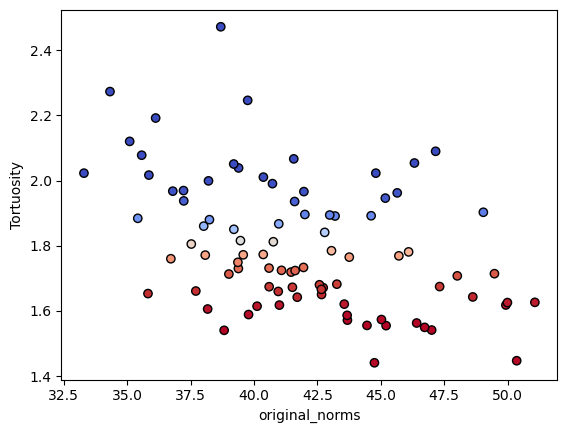

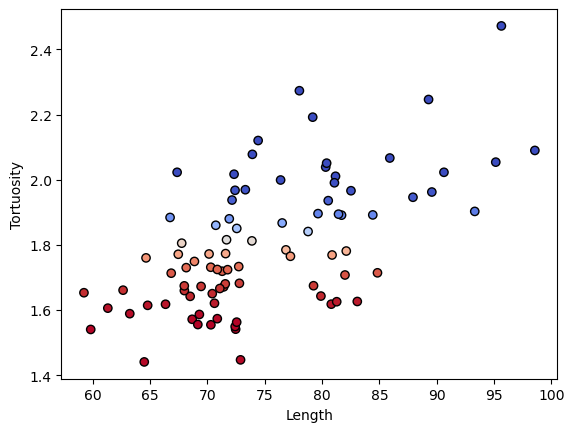

original_norms vs Tortuosity 相关系数: -0.436, p值: 2.153e-05
Length vs Tortuosity 相关系数: 0.602, p值: 5.369e-10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4007.
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           7.79e-85
Time:                        16:57:27   Log-Likelihood:                 218.65
No. Observations:                  88   AIC:                            -431.3
Df Residuals:                      85   BIC:                            -423.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [56]:
plt.scatter(original_norms, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("original_norms")
plt.ylabel("Tortuosity")
plt.show()

plt.scatter(original_lengths, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("Length")
plt.ylabel("Tortuosity")
plt.show()

from scipy.stats import pearsonr

# 计算 original_norms 和 original_tortuosities 之间的相关系数
corr_norm_tort, p_value_norm = pearsonr(original_norms, original_tortuosities)
print(f"original_norms vs Tortuosity 相关系数: {corr_norm_tort:.3f}, p值: {p_value_norm:.3e}")

# 计算 original_lengths 和 original_tortuosities 之间的相关系数
corr_length_tort, p_value_length = pearsonr(original_lengths, original_tortuosities)
print(f"Length vs Tortuosity 相关系数: {corr_length_tort:.3f}, p值: {p_value_length:.3e}")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.column_stack([original_lengths, original_norms]))
X_scaled = sm.add_constant(X_scaled)
y = original_tortuosities

model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())



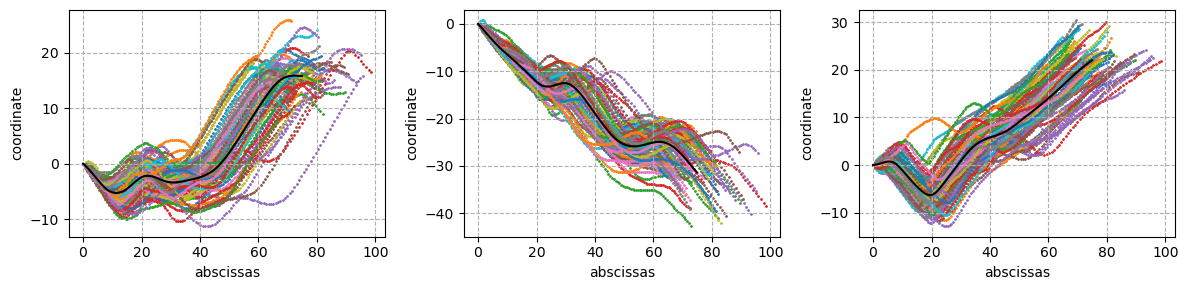

original_centerlines shape: (88, 120, 3)
abscissas shape: (88, 120)


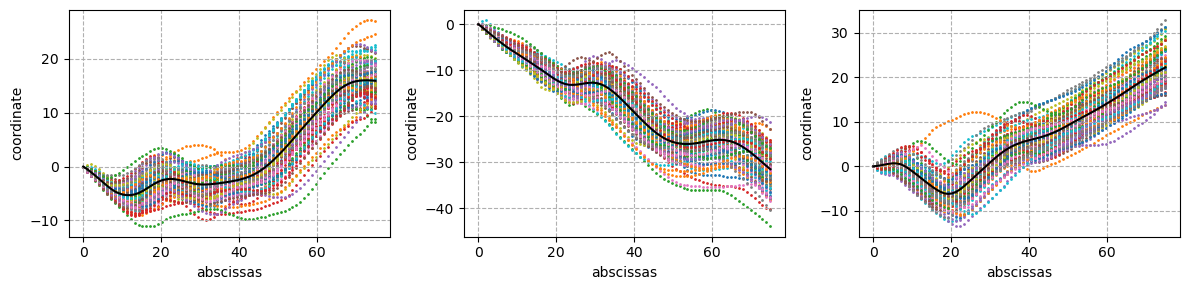

original_centerlines shape: (88, 75, 3)
abscissas shape: (88, 75)


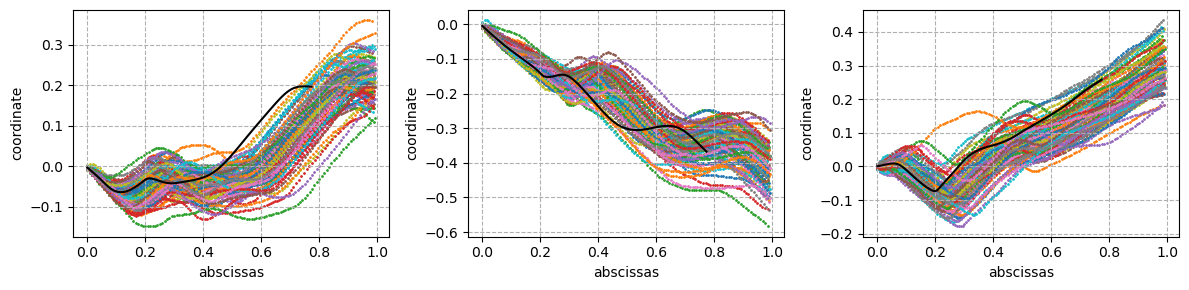

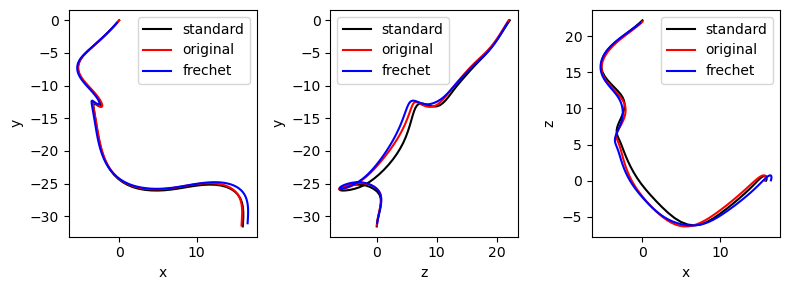

length of resampled_standardized_mean_cl: 65.69323485155365
length of original_mean_cl: 66.1268895178694
length of frechet mean shape: 65.31927550379855
tortuosity of resampled standardized mean curve:
1.5735688164245851
tortuosity of original mean curve:
1.5945059012690193
tortuosity of frechet mean curve:
1.5848965786849918


In [57]:
fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
original_mean_cl = np.mean(original_centerlines_copy, axis=0)
original_mean_abscissas = np.mean(abscissas, axis=0)
ax1.plot(original_mean_abscissas,original_mean_cl[:,0],color='k')
ax2.plot(original_mean_abscissas,original_mean_cl[:,1],color='k')
ax3.plot(original_mean_abscissas,original_mean_cl[:,2],color='k')
for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i],original_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(abscissas[i],original_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(abscissas[i],original_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
plt.tight_layout()
plt.show()

print ("original_centerlines shape:", original_centerlines_copy.shape)
print ("abscissas shape:", abscissas.shape)

# 插值到1mm/point,缩放

fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
resampled_standardized_mean_cl = np.mean(resampled_standardized_centerlines_copy, axis=0)
resampled_standardized_mean_abscissas = np.mean(resampled_standardized_abscissas, axis=0)

for i in range(len(original_centerlines)):
    ax1.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
ax1.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,0],color='k')
ax2.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,1],color='k')
ax3.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,2],color='k')

plt.tight_layout()
plt.show()

print ("original_centerlines shape:", resampled_standardized_centerlines.shape)
print ("abscissas shape:", resampled_standardized_abscissas.shape)

fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

mean_estimate_abscissas = calculate_abscissas(mean_estimate)
curve_cs_abscissas = []
for i in range(len(curve_cs)):
    curve_cs_abscissas.append(calculate_abscissas(curve_cs[i]))
curve_cs_abscissas = np.array(curve_cs_abscissas)
ax1.plot(mean_estimate_abscissas,mean_estimate[:,0],color='k')
ax2.plot(mean_estimate_abscissas,mean_estimate[:,1],color='k')
ax3.plot(mean_estimate_abscissas,mean_estimate[:,2],color='k')
for i in range(len(curve_cs)):
    ax1.scatter(curve_cs_abscissas[i],curve_cs[i][:,0],marker='o',s=1)
    ax2.scatter(curve_cs_abscissas[i],curve_cs[i][:,1],marker='o',s=1)
    ax3.scatter(curve_cs_abscissas[i],curve_cs[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")

plt.tight_layout()
plt.show()

adjust_mean_k =84.5

fig = plt.figure(figsize=(8,3), dpi=100)
ax1 = fig.add_subplot(131)
ax1.plot(resampled_standardized_mean_cl[:,0],resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax1.plot(original_mean_cl[:,0],original_mean_cl[:,1],color='r',label='original')
ax1.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2 = fig.add_subplot(132)
ax2.plot(resampled_standardized_mean_cl[:,2][::-1],resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax2.plot(original_mean_cl[:,2][::-1],original_mean_cl[:,1],color='r',label='original')
ax2.plot(mean_estimate[:,2][::-1]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("y")
ax3 = fig.add_subplot(133)
ax3.plot(resampled_standardized_mean_cl[:,0],resampled_standardized_mean_cl[:,2][::-1],color='k',label='standard')
ax3.plot(original_mean_cl[:,0],original_mean_cl[:,2][::-1],color='r',label='original')
ax3.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("z")
plt.tight_layout()
plt.show()


print ("length of resampled_standardized_mean_cl:", calculate_curve_length(resampled_standardized_mean_cl))
print ("length of original_mean_cl:", calculate_curve_length(original_mean_cl))
print ("length of frechet mean shape:", calculate_curve_length(adjust_mean_k*mean_estimate))
print ("tortuosity of resampled standardized mean curve:")
print(calculate_curve_length(resampled_standardized_mean_cl)/np.linalg.norm(resampled_standardized_mean_cl[-1]-resampled_standardized_mean_cl[0]))
print ("tortuosity of original mean curve:")
print(calculate_curve_length(original_mean_cl)/np.linalg.norm(original_mean_cl[-1]-original_mean_cl[0]))
print ("tortuosity of frechet mean curve:")
print(calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0]))



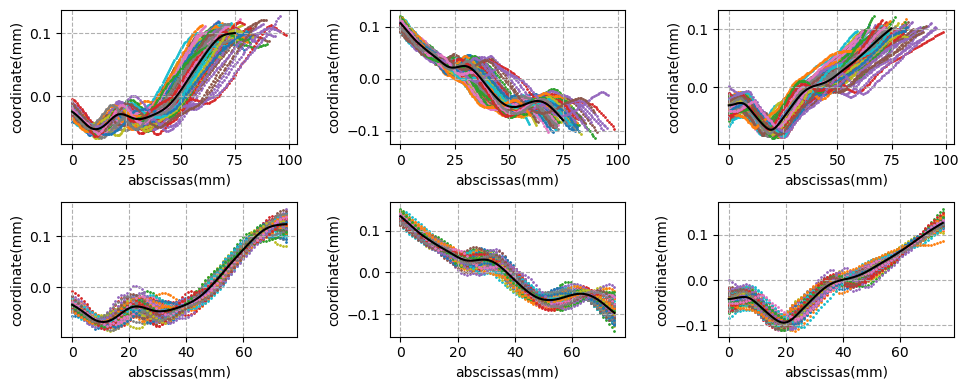

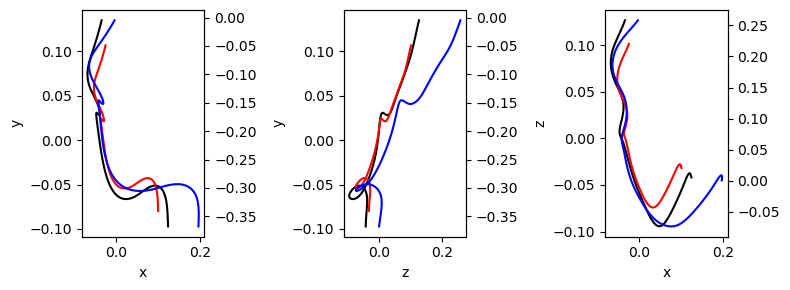

length of resampled_standardized_mean_cl: 0.5213752181774339
length of original_mean_cl: 0.4187309405764255
length of frechet mean shape: 0.7730091775597462
tortuosity of resampled standardized mean curve:
1.5913383049688308
tortuosity of original mean curve:
1.603877003135402
tortuosity of frechet mean curve:
1.5848965786849918


In [58]:
# After aligning the curves, we can visualize the aligned curves in 3D space.

original_centerlines = align_centerlines_procrustes(original_centerlines)
resampled_standardized_centerlines = align_centerlines_procrustes(resampled_standardized_centerlines)

aligned_original_mean_cl = np.mean(original_centerlines, axis=0)
# aligned_original_mean_abscissas = calculate_abscissas(aligned_original_mean_cl)
aligned_original_mean_abscissas = np.mean(abscissas, axis=0)
aligned_resampled_standardized_mean_cl = np.mean(resampled_standardized_centerlines, axis=0)
# aligned_resampled_standardized_mean_abscissas = calculate_abscissas(aligned_resampled_standardized_mean_cl)
aligned_resampled_standardized_mean_abscissas = np.mean(resampled_standardized_abscissas, axis=0)


# 可视化对齐后的曲线
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i], original_centerlines[i][:, 0], marker='o', s=1)
    ax2.scatter(abscissas[i], original_centerlines[i][:, 1], marker='o', s=1)
    ax3.scatter(abscissas[i], original_centerlines[i][:, 2], marker='o', s=1)
    ax4.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 0], marker='o', s=1)
    ax5.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 1], marker='o', s=1)
    ax6.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 2], marker='o', s=1)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("abscissas(mm)")
    ax.set_ylabel("coordinate(mm)")
    ax.grid(linestyle="--")

ax1.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 0], color='k', label='mean')
ax2.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 1], color='k', label='mean')
ax3.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 2], color='k', label='mean')
ax4.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 0], color='k', label='mean')
ax5.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 1], color='k', label='mean')
ax6.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 2], color='k', label='mean')


plt.tight_layout()
plt.show()


adjust_mean_k =1
fig = plt.figure(figsize=(8,3), dpi=100)
ax1 = fig.add_subplot(131)
ax1.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax1.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,1],color='r',label='original')
ax1_twin = ax1.twinx()
ax1_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
# ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2 = fig.add_subplot(132)
ax2.plot(aligned_resampled_standardized_mean_cl[:,2][::-1],aligned_resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax2.plot(aligned_original_mean_cl[:,2][::-1],aligned_original_mean_cl[:,1],color='r',label='original')
ax2_twin = ax2.twinx()
ax2_twin.plot(mean_estimate[:,2][::-1]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
# ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("y")
ax3 = fig.add_subplot(133)
ax3.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,2][::-1],color='k',label='standard')
ax3.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,2][::-1],color='r',label='original')
ax3_twin = ax3.twinx()
ax3_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
# ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("z")
plt.tight_layout()
plt.show()

print ("length of resampled_standardized_mean_cl:", calculate_curve_length(aligned_resampled_standardized_mean_cl))
print ("length of original_mean_cl:", calculate_curve_length(aligned_original_mean_cl))
print ("length of frechet mean shape:", calculate_curve_length(adjust_mean_k*mean_estimate))
print ("tortuosity of resampled standardized mean curve:")
print(calculate_curve_length(aligned_resampled_standardized_mean_cl)/np.linalg.norm(aligned_resampled_standardized_mean_cl[-1]-aligned_resampled_standardized_mean_cl[0]))
print ("tortuosity of original mean curve:")
print(calculate_curve_length(aligned_original_mean_cl)/np.linalg.norm(aligned_original_mean_cl[-1]-aligned_original_mean_cl[0]))
print ("tortuosity of frechet mean curve:")
print(calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0]))

interpolated_std_centerlines.shape: (88, 750, 3)
interval:, 0.1 explained_variance_ratio_: [0.2735907  0.1751554  0.11484565 0.09296243 0.06886902 0.05329189
 0.04358864 0.04150519 0.02542682 0.02258767]
interpolated_std_centerlines.shape: (88, 250, 3)
interval:, 0.3 explained_variance_ratio_: [0.27317857 0.17528902 0.11450987 0.09273162 0.06915497 0.05354221
 0.04369288 0.04160184 0.02515406 0.02269927]
interpolated_std_centerlines.shape: (88, 75, 3)
interval:, 1.0 explained_variance_ratio_: [0.2714788  0.17580995 0.11348145 0.09202623 0.07008048 0.05448704
 0.04411596 0.04181306 0.02423358 0.02305008]
interpolated_std_centerlines.shape: (88, 25, 3)
interval:, 3.0 explained_variance_ratio_: [0.26634968 0.17680529 0.1115764  0.09058788 0.07166251 0.05709113
 0.04540511 0.04160572 0.02436134 0.02155282]
(4, 88, 10)


C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\228351093.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\228351093.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


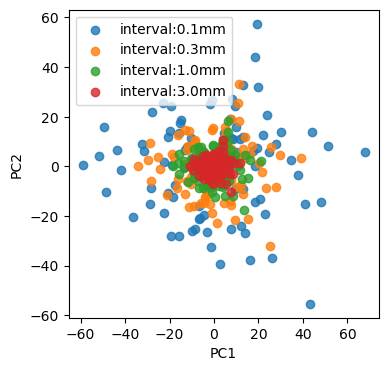

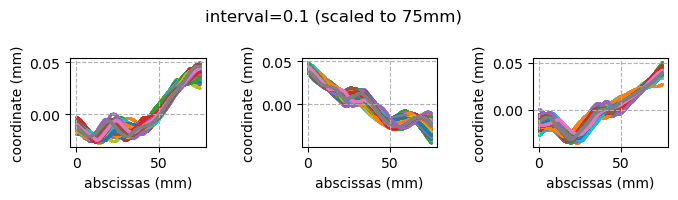

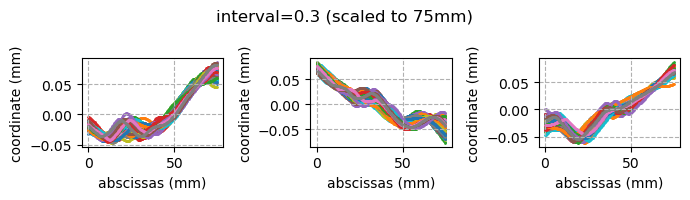

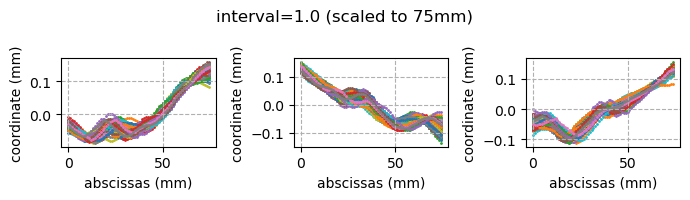

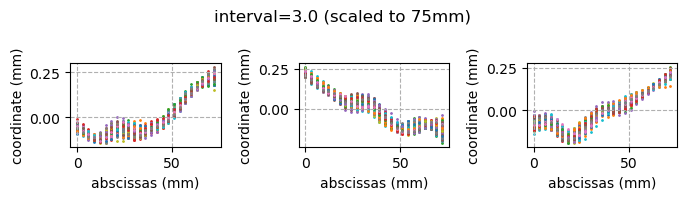

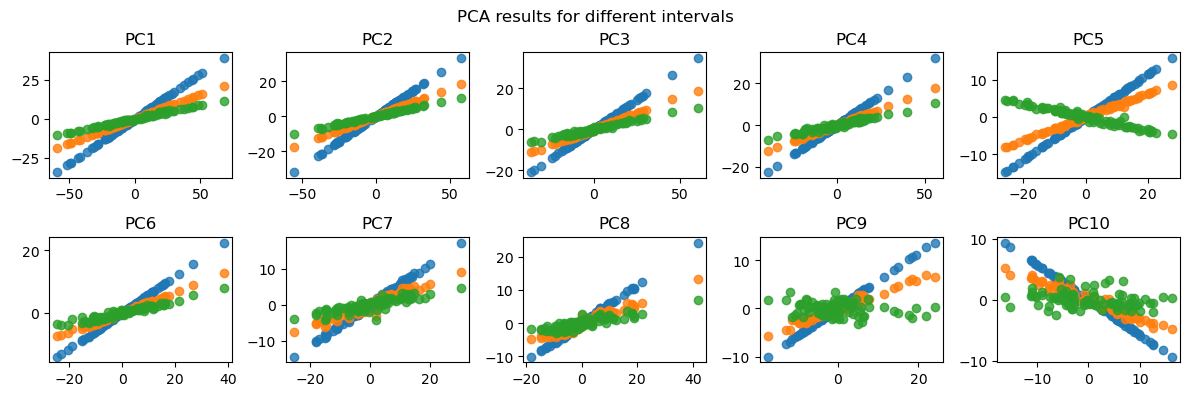

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 10
def resample_centerlines_by_interval(abscissas, original_centerlines, interval):
    num_curves, num_points = abscissas.shape
    
    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        # 获取当前曲线的abscissas和centerlines
        x = abscissas[i]
        y = original_centerlines[i]

        # 确保 x 是单调递增的
        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的采样点
        new_x = np.arange(x[0], x[-1], interval)
        resampled_abscissas.append(new_x)

        # 对 centerlines 进行插值
        interp_func = interp1d(x, y, axis=0, kind='linear', fill_value='extrapolate')
        new_y = interp_func(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.add_subplot(111)

std_results = []
interval_var =[0.1,0.3,1.0,3.0]
for interval in interval_var:
    fig2 = plt.figure(figsize=(7,2), dpi=100)
    fig2.suptitle(f"interval={interval} (scaled to 75mm)")
    ax2_1 = fig2.add_subplot(131)
    ax2_2 = fig2.add_subplot(132)
    ax2_3 = fig2.add_subplot(133)
    for  ax in [ax2_1, ax2_2, ax2_3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(resampled_standardized_abscissas, 
                                                                                        resampled_standardized_centerlines, 
                                                                                        interval)

    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    print ("interpolated_std_centerlines.shape:", interpolated_std_centerlines.shape)


    for j in range(len(interpolated_std_centerlines)):
        ax2_1.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 0], marker='o', s=1)
        ax2_2.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 1], marker='o', s=1)
        ax2_3.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 2], marker='o', s=1)
    X = interpolated_std_centerlines.reshape(curve_bs.shape[0], -1)
    fig2.tight_layout(rect=[0, 0, 1, 0.96])
    # 进行标准化 (Z-score)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 进行 PCA
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    std_results.append(result)
    print ("interval:,",interval,"explained_variance_ratio_:", pca.explained_variance_ratio_)

    ax1.scatter(result[:, 0], result[:, 1], alpha=.8, label="interval:"+str(interval)+"mm")
    
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend()
fig1.show()

std_results = np.array(std_results)
print (std_results.shape)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(std_results)):
        axes[i].scatter(std_results[0][:, i], std_results[j][:, i], label=f"iv={interval_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different intervals") 
fig.show()

C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


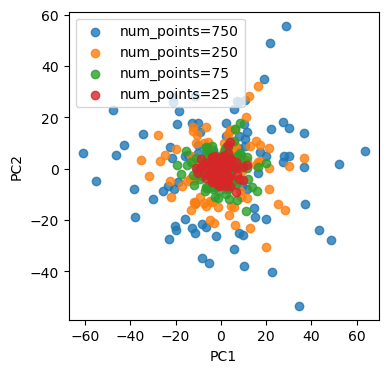

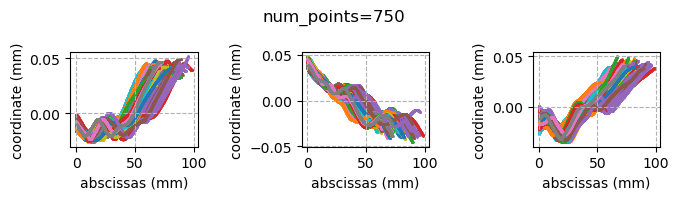

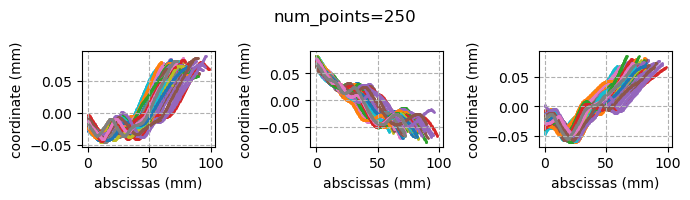

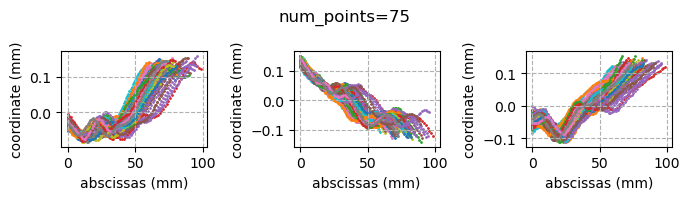

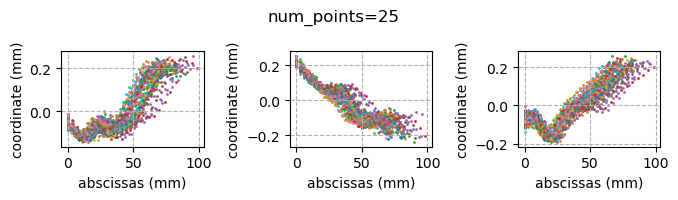

C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


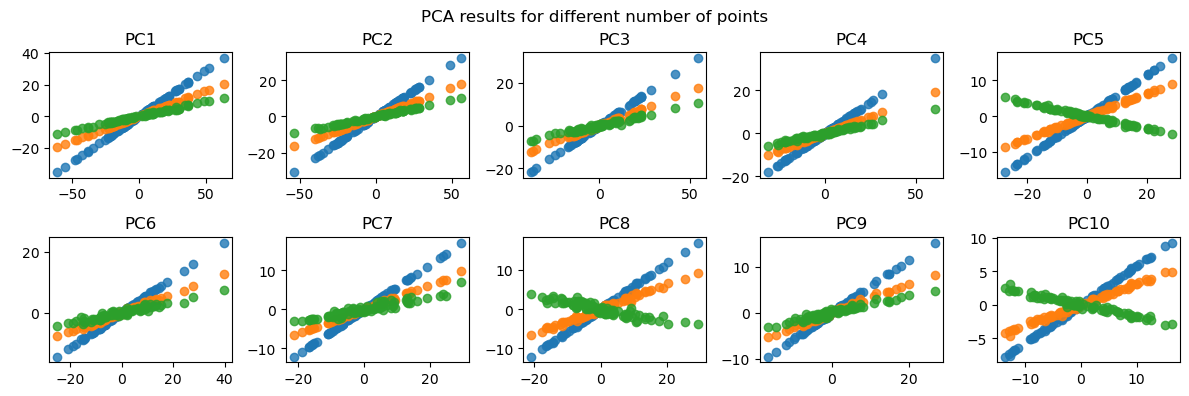

In [60]:
n_components = 10

def resample_centerlines_by_points(abscissas, original_centerlines, num_points):
    num_curves, num_original_points = abscissas.shape

    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        x = abscissas[i]
        y = original_centerlines[i]

        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的等间距 abscissas（保持原始范围）
        new_x = np.linspace(x[0], x[-1], num_points)

        # 对 centerlines 进行插值
        curve_func = parameterize_curve(y)
        new_y = curve_func(np.linspace(0, 1, num_points))  # 按参数化均匀采样

        resampled_abscissas.append(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

original_resampling_data = {}
non_std_results = []

fig_pca = plt.figure(figsize=(4, 4), dpi=100)
ax_pca = fig_pca.add_subplot(111)

points_var =[750, 250, 75, 25]
for num_points in points_var:
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)
    new_centerlines = align_centerlines_procrustes(new_centerlines)
    X = new_centerlines.reshape(curve_bs.shape[0], -1)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    ax_pca.scatter(result[:, 0], result[:, 1], label=f"num_points={num_points}",alpha=.8)
    non_std_results.append(result)


    fig = plt.figure(figsize=(7, 2), dpi=100)
    fig.suptitle(f"num_points={num_points}")
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    for i in range(len(original_centerlines)):
        ax1.scatter(new_abscissas[i], new_centerlines[i][:, 0], marker='o', s=1)
        ax2.scatter(new_abscissas[i], new_centerlines[i][:, 1], marker='o', s=1)
        ax3.scatter(new_abscissas[i], new_centerlines[i][:, 2], marker='o', s=1)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")

    fig.tight_layout()
    fig.show()
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.legend()
plt.show(fig_pca)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(non_std_results)):
        axes[i].scatter(non_std_results[0][:, i], non_std_results[j][:, i], label=f"n_pts={points_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different number of points")
fig.show()



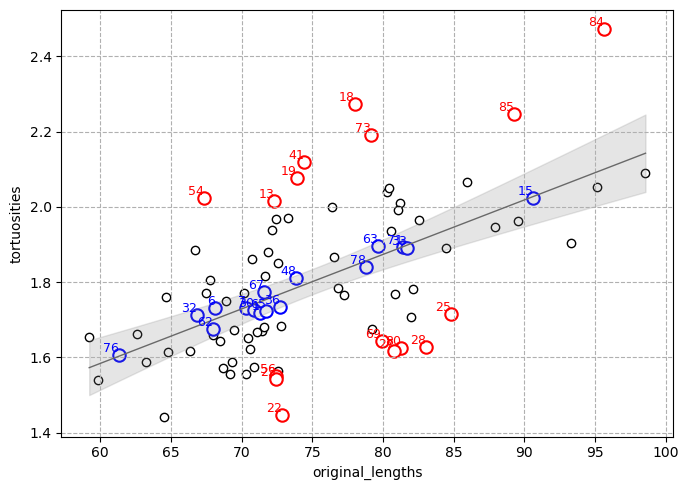

Confidence interval width at x=78.893: 0.075
Indices of points farthest from the line: [56 23 69 25 85 13 80 27 28 19 22 41 73 54 84 18]
Indices of points closest to the line: [71  7 76 15 33 78 30 67 62 48 63  1  6 65 32 36]
71 brava_cut_mirrored\BH0038_ICA_L.vtk
7 brava_cut_mirrored\BG0007_ICA_R.vtk
76 brava_cut_mirrored\BI0001_ICA_L.vtk
15 brava_cut_mirrored\BG0011_ICA_R.vtk
33 brava_cut_mirrored\BH0009_ICA_L.vtk
78 250216tuika\BG0015_L_reverse_MirroredV2.vtk
30 brava_cut_mirrored\BH0005_ICA_R.vtk
67 brava_cut_mirrored\BH0034_ICA_R.vtk
62 brava_cut_mirrored\BH0030_ICA_L.vtk
48 brava_cut_mirrored\BH0018_ICA_R.vtk
63 brava_cut_mirrored\BH0030_ICA_R.vtk
1 brava_cut_mirrored\BG0001_ICA_R.vtk
6 brava_cut_mirrored\BG0007_ICA_L.vtk
65 brava_cut_mirrored\BH0031_ICA_R.vtk
32 brava_cut_mirrored\BH0006_ICA_R.vtk
36 brava_cut_mirrored\BH0010_ICA_R.vtk


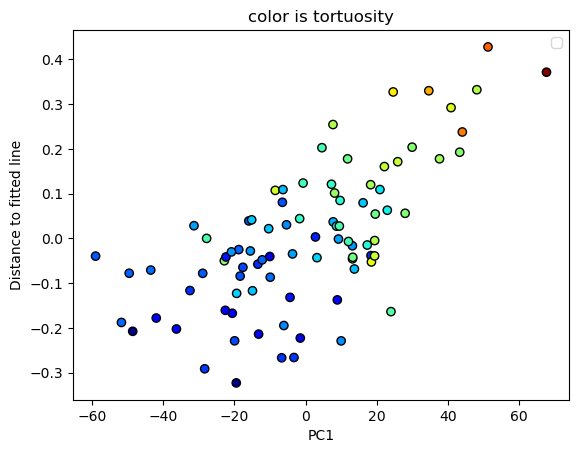

In [61]:
n_highlight = 16  # 需要标出的离散点数量
n_closest = 16  # 需要标出的最近点数量

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

# 绘制散点图
sc = ax.scatter(original_lengths, original_tortuosities, color='w', edgecolors='k')
ax.set_ylabel("tortuosities")
ax.set_xlabel("original_lengths")
ax.grid(linestyle="--")

# 线性回归 - statsmodels
X = sm.add_constant(original_lengths)
model = sm.OLS(original_tortuosities, X).fit()

# 获取拟合直线上的 y 值
y_fitted = model.predict(X)

# 计算残差（垂直距离，带符号）
residuals = original_tortuosities - y_fitted

# 找到离直线最远的 n 个点的索引
sorted_indices = np.argsort(np.abs(residuals))[-n_highlight:]

# 标出最远的 n 个点，用红色边框
for idx in sorted_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='red', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='red')
# 找到离直线最近的 n 个点的索引
closest_indices = np.argsort(np.abs(residuals))[:n_closest]

# 标出最近的 n 个点，用蓝色边框
for idx in closest_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='blue', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='blue')

# 绘制拟合直线
x_fit = np.linspace(min(original_lengths), max(original_lengths), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)
ax.plot(x_fit, y_fit, color='dimgray', linestyle='-', linewidth=1, label="Fitted Line")

# 获取置信区间 (95%)
pred = model.get_prediction(X_fit)
conf_int = pred.conf_int(alpha=0.05)  # (100, 2)

# 绘制置信区间
ax.fill_between(x_fit, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label="95% Confidence Interval")

plt.tight_layout()
plt.show()

# 计算 x 轴中点处的置信区间宽度
x_mid = np.median(x_fit)
X_mid = np.array([[1, x_mid]])  # 手动组合常数项和 x 值

y_mid_pred = model.predict(X_mid)[0]

# 注意这里也用 X_mid，不要再调用 sm.add_constant()
conf_int_mid = model.get_prediction(X_mid).conf_int(alpha=0.05)[0]
conf_int_width = conf_int_mid[1] - conf_int_mid[0]

print(f"Confidence interval width at x={x_mid:.3f}: {conf_int_width:.3f}")



print("Indices of points farthest from the line:", sorted_indices)
print("Indices of points closest to the line:", closest_indices)
for idx in closest_indices:
    print(idx, files[idx])

def get_distances_to_fit(original_lengths, original_tortuosities):
    # 线性回归 - statsmodels
    X = sm.add_constant(original_lengths)
    model = sm.OLS(original_tortuosities, X).fit()

    # 计算残差（带符号距离）
    y_fitted = model.predict(X)
    residuals = original_tortuosities - y_fitted  # 每个点到拟合直线的垂直距离（正负）

    return residuals

distances = get_distances_to_fit(original_lengths, original_tortuosities)
abs_distances = np.abs(distances)

plt.scatter(std_results[0][:, 0], distances, c=original_tortuosities, cmap='jet', edgecolors='k')
# plt.axhline(y=conf_int_width, color='k', linestyle='--', linewidth=1, label=f"CI Width = {conf_int_width:.3f}")
# plt.axhline(y=2*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"2*CI Width = {2*conf_int_width:.3f}",alpha=0.6)
# plt.axhline(y=3*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"3*CI Width = {3*conf_int_width:.3f}",alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("Distance to fitted line")
plt.title("color is tortuosity")
plt.legend()
plt.show()



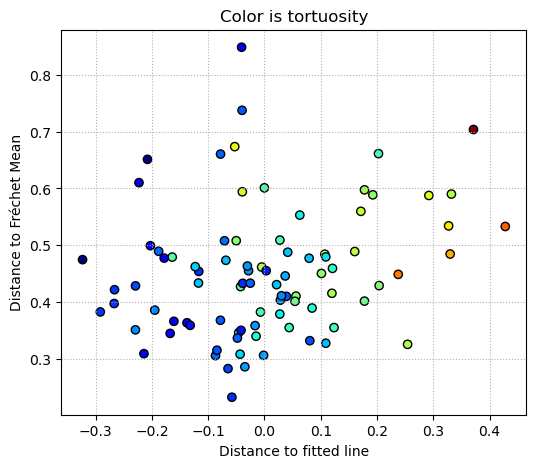

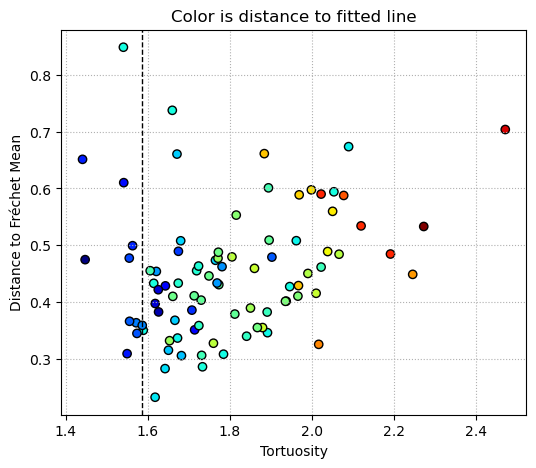

In [62]:
fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(distances, g_dist_to_frechet, c=original_tortuosities, cmap='jet', edgecolors='k')
ax.set_xlabel("Distance to fitted line")
ax.set_ylabel("Distance to Fréchet Mean")
ax.set_title("Color is tortuosity")
ax.grid(linestyle=":")
plt.show()


fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(original_tortuosities, g_dist_to_frechet, c=distances,cmap='jet', edgecolors='k')
ax.axvline(mean_estimate_tortuosity, color='k', linestyle='--', linewidth=1, label="Mean Estimate Tortuosity")
ax.set_xlabel("Tortuosity")
ax.set_ylabel("Distance to Fréchet Mean")
ax.set_title("Color is distance to fitted line")
ax.grid(linestyle=":")
plt.show()

X shape: (88, 225)
PCA transformed shape: (88, 10)


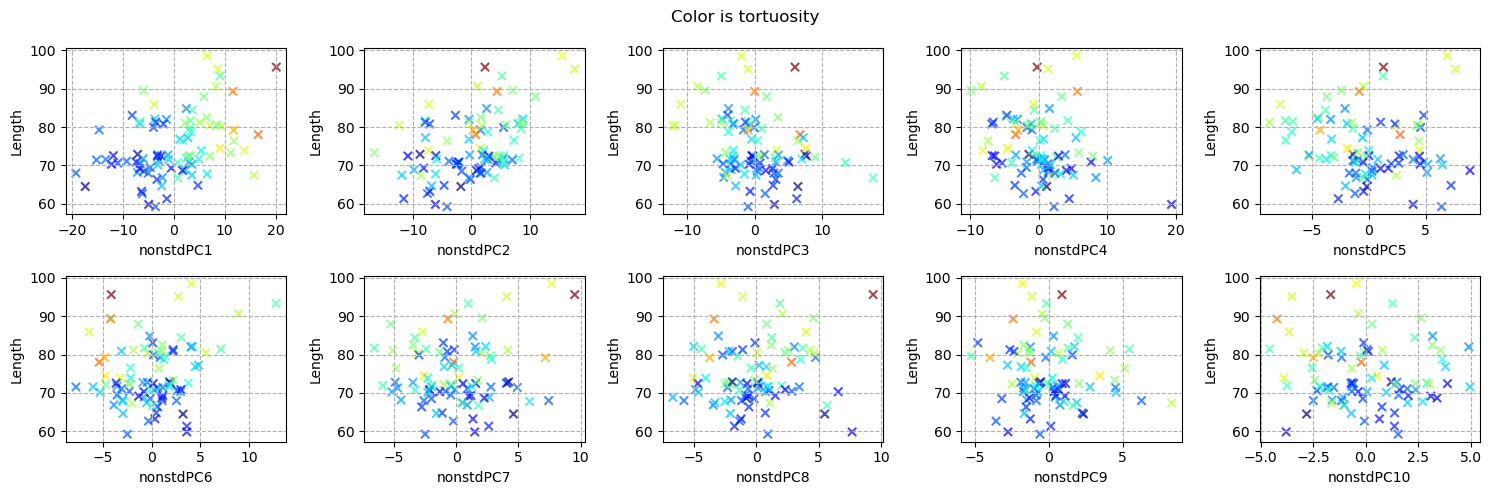

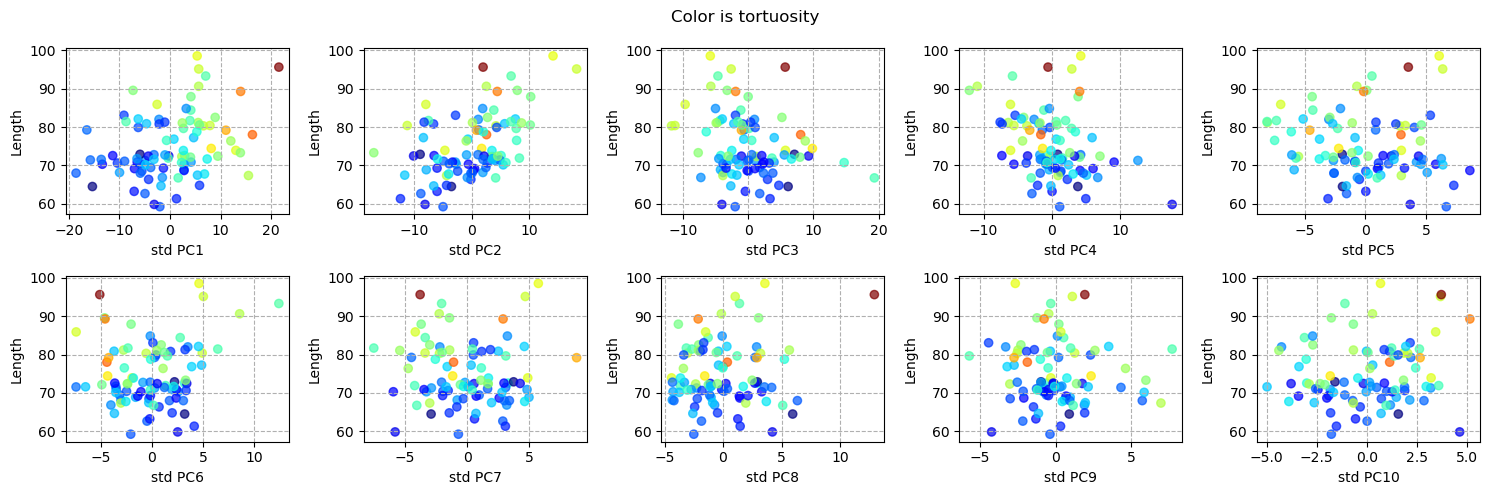

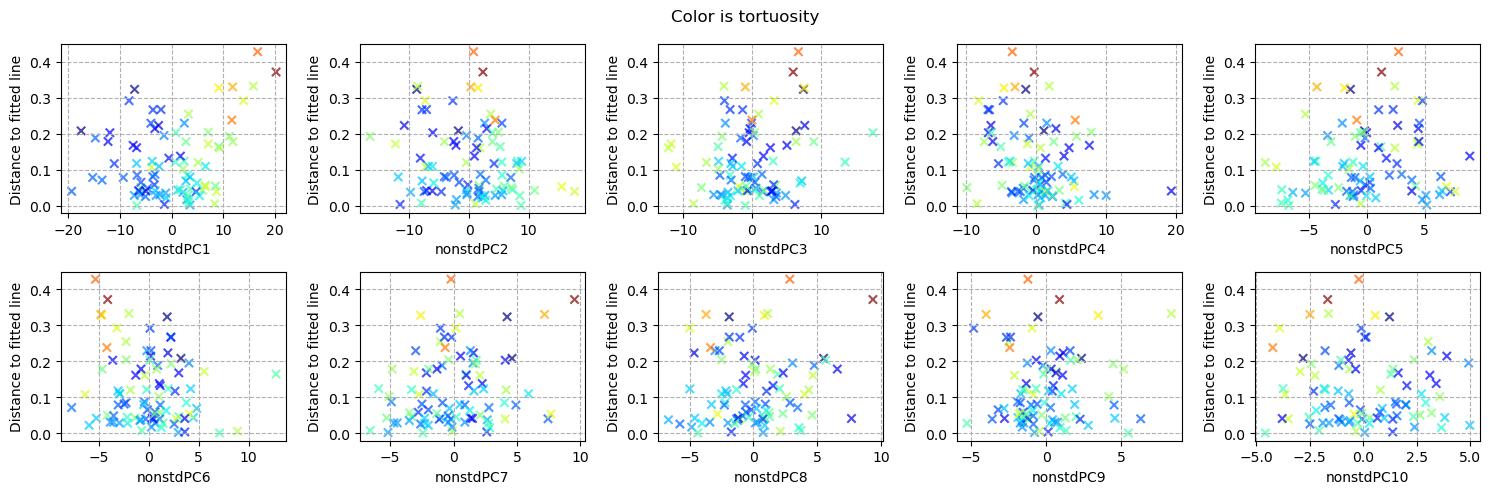

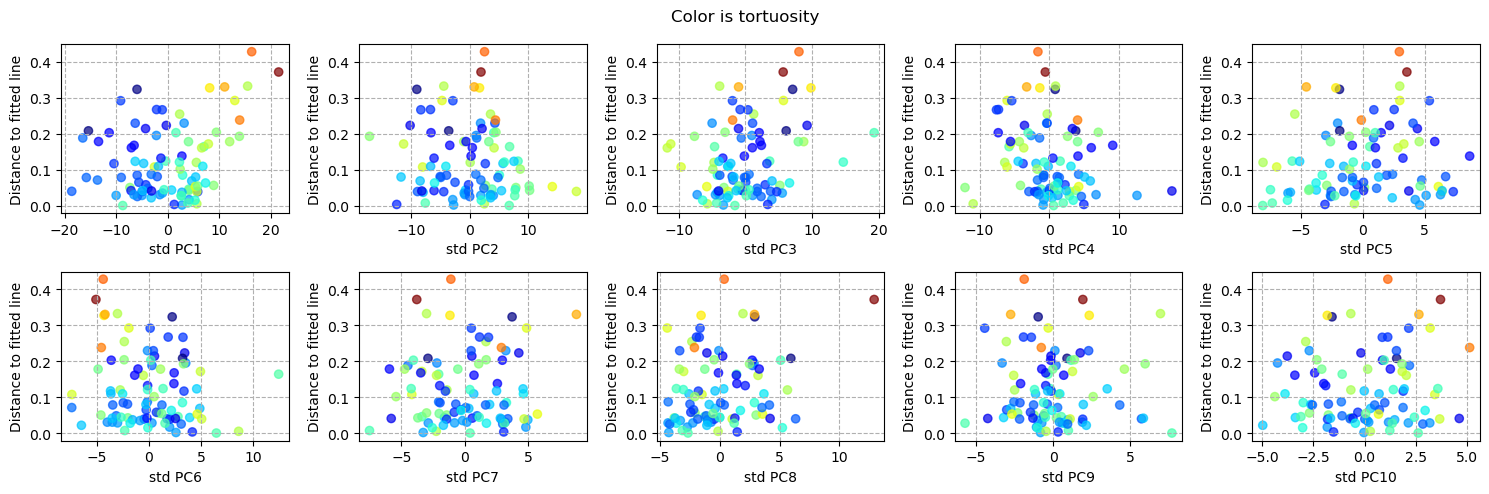

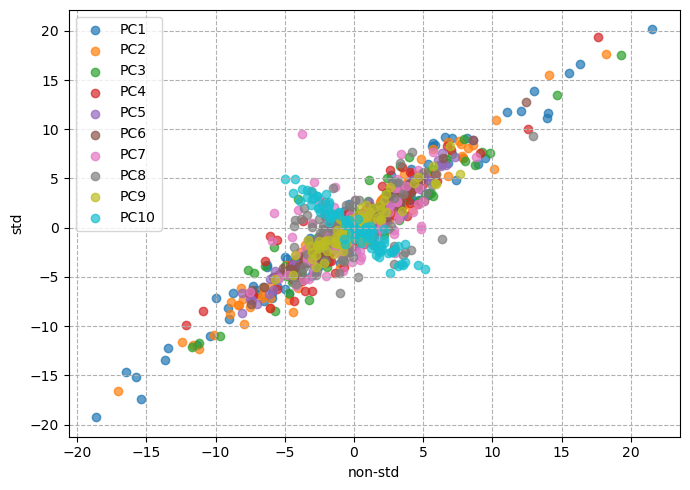

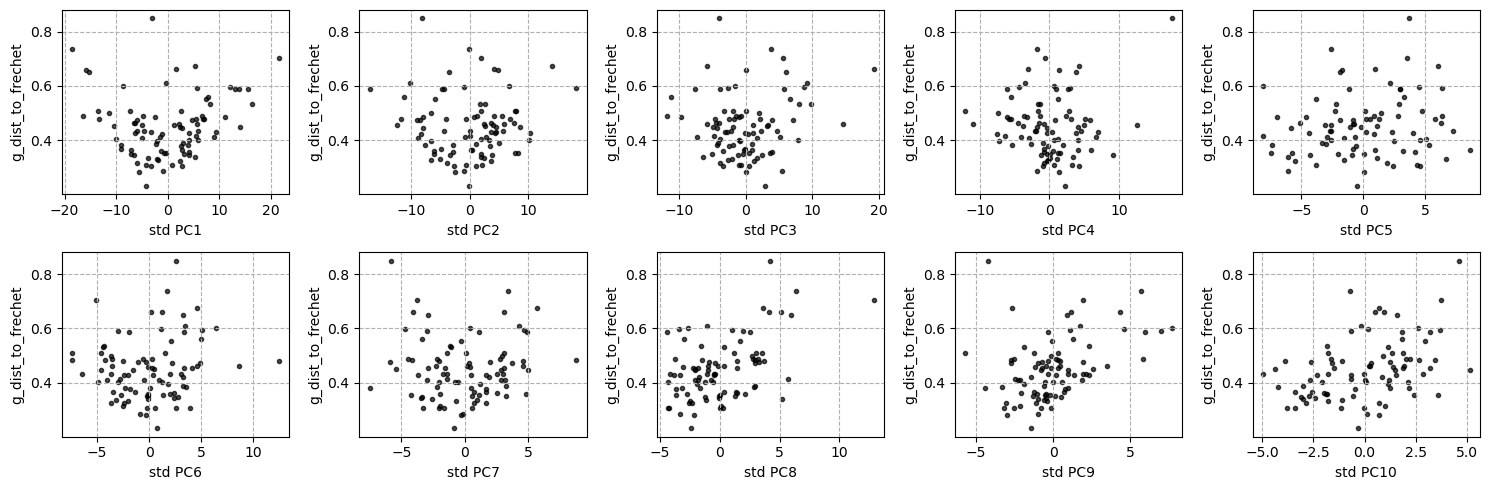

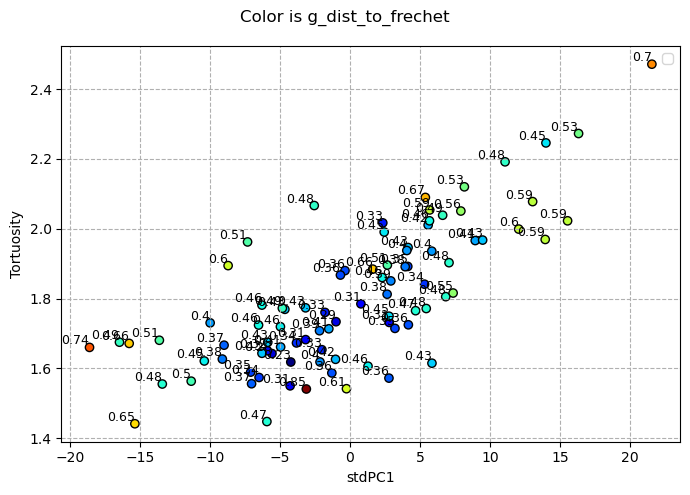

In [63]:
# 将数据 reshape 为 (79, 3*m)
X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1) # 标准化到75mm的centerlines
print ("X shape:", X.shape)

# 进行标准化 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 进行 PCA
std_pca = PCA(n_components=n_components)
std_pca_result = std_pca.fit_transform(X_scaled)

print("PCA transformed shape:", std_pca_result.shape)  # (79, 3)

_, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=75)
new_centerlines = np.array(new_centerlines)
X = new_centerlines.reshape(curve_bs.shape[0], -1)
X_scaled = StandardScaler().fit_transform(X)

non_std_pca = PCA(n_components=n_components)
non_std_pca_result = non_std_pca.fit_transform(X_scaled)


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    # ax.scatter(std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    ax.scatter(non_std_pca_result[:, i], original_lengths, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Length")
    ax.set_xlabel(f"nonstdPC{i+1}")
    ax.grid(linestyle="--")
fig.suptitle("Color is tortuosity")
plt.tight_layout()    
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.scatter(std_pca_result[:, i], original_lengths, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    # ax.scatter(non_std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Length")
    ax.set_xlabel(f"std PC{i+1}")
    ax.grid(linestyle="--")
fig.suptitle("Color is tortuosity")
plt.tight_layout()    
plt.show()









fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    # ax.scatter(std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    ax.scatter(non_std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Distance to fitted line")
    ax.set_xlabel(f"nonstdPC{i+1}")
    ax.grid(linestyle="--")
fig.suptitle("Color is tortuosity")
plt.tight_layout()    
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.scatter(std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='o')
    # ax.scatter(non_std_pca_result[:, i], abs_distances, label=f"PC{i+1}", alpha=0.7, c=original_tortuosities,marker='x')
    ax.set_ylabel("Distance to fitted line")
    ax.set_xlabel(f"std PC{i+1}")
    ax.grid(linestyle="--")
fig.suptitle("Color is tortuosity")
plt.tight_layout()    
plt.show()



fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
for i in range(n_components):
    ax.scatter(std_pca_result[:, i], non_std_pca_result[:, i], label=f"PC{i+1}", alpha=0.7, marker='o')
ax.set_ylabel("std")
ax.set_xlabel("non-std")
ax.grid(linestyle="--")
ax.legend()
plt.tight_layout()    
plt.show()


fig, axes = plt.subplots(2, 5, figsize=(15, 5), dpi=100)
axes = axes.flatten()
for i in range(n_components):
    ax = axes[i]
    ax.scatter(std_pca_result[:, i], g_dist_to_frechet, label=f"PC{i+1}", alpha=0.7, c='k',marker='.')
    ax.set_ylabel("g_dist_to_frechet")
    ax.set_xlabel(f"std PC{i+1}")
    ax.grid(linestyle="--")

plt.tight_layout()    
plt.show()


fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
new_query = g_dist_to_frechet * distances
ax.scatter(std_pca_result[:, 0], original_tortuosities[:], c=g_dist_to_frechet, cmap='jet', edgecolors='k')
for i in range(len(files)):
    ax.text(std_pca_result[i, 0], original_tortuosities[i], str(round(g_dist_to_frechet[i],2)), fontsize=9, ha='right', va='bottom', color='black')
ax.set_ylabel("Tortuosity")
ax.set_xlabel("stdPC1")
ax.grid(linestyle="--")
ax.legend()
fig.suptitle("Color is g_dist_to_frechet")
plt.tight_layout()    
plt.show()


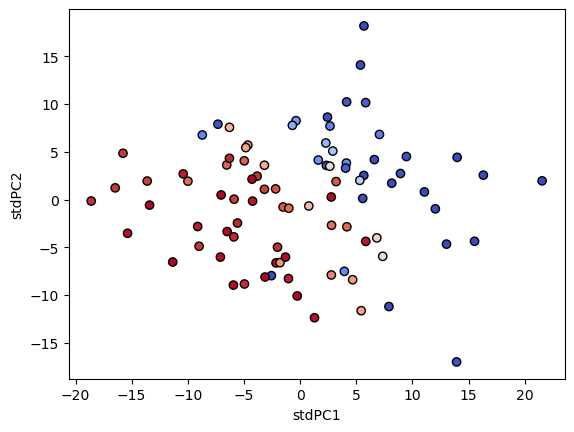

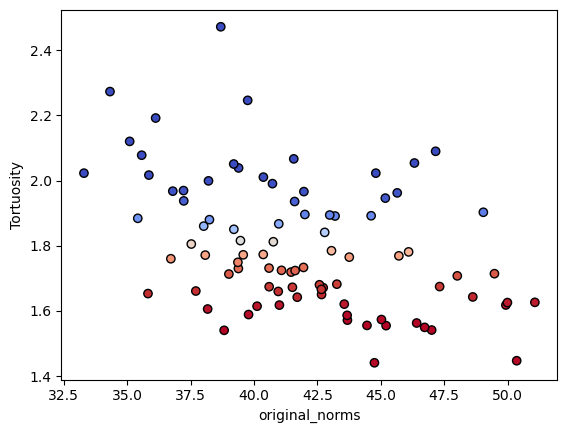

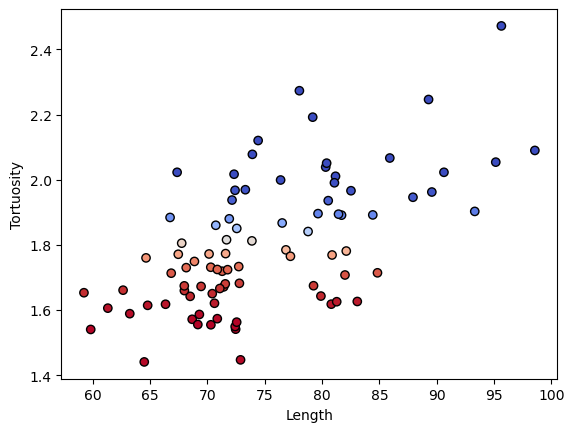

original_norms vs Tortuosity 相关系数: -0.436, p值: 2.153e-05
Length vs Tortuosity 相关系数: 0.602, p值: 5.369e-10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4007.
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           7.79e-85
Time:                        17:01:54   Log-Likelihood:                 218.65
No. Observations:                  88   AIC:                            -431.3
Df Residuals:                      85   BIC:                            -423.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [68]:


plt.scatter(std_pca_result[:, 0], std_pca_result[:,1], c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("stdPC1")
plt.ylabel("stdPC2")
plt.show()

plt.scatter(original_norms, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("original_norms")
plt.ylabel("Tortuosity")
plt.show()

plt.scatter(original_lengths, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("Length")
plt.ylabel("Tortuosity")
plt.show()

from scipy.stats import pearsonr

# 计算 original_norms 和 original_tortuosities 之间的相关系数
corr_norm_tort, p_value_norm = pearsonr(original_norms, original_tortuosities)
print(f"original_norms vs Tortuosity 相关系数: {corr_norm_tort:.3f}, p值: {p_value_norm:.3e}")

# 计算 original_lengths 和 original_tortuosities 之间的相关系数
corr_length_tort, p_value_length = pearsonr(original_lengths, original_tortuosities)
print(f"Length vs Tortuosity 相关系数: {corr_length_tort:.3f}, p值: {p_value_length:.3e}")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.column_stack([original_lengths, original_norms]))
X_scaled = sm.add_constant(X_scaled)
y = original_tortuosities

model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())



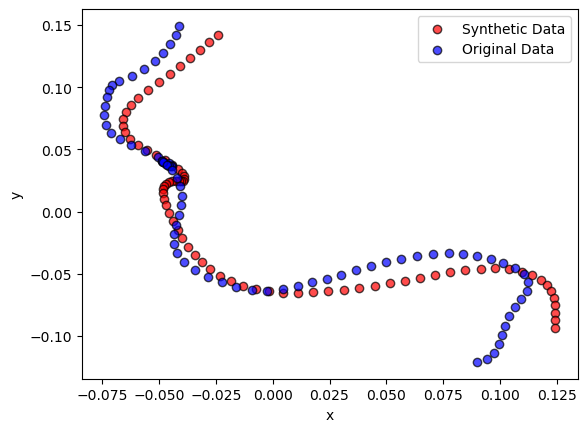

In [69]:
# 预处理数据
scaler = StandardScaler()
std_X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1)
std_X_scaled = scaler.fit_transform(std_X)

# PCA 降维
std_PCA = PCA(n_components=10)
std_PCA_features = std_PCA.fit_transform(std_X_scaled)

# 计算 PCA 特征的均值和协方差
std_PCA_features_mean = np.mean(std_PCA_features, axis=0)
std_PCA_features_cov = np.cov(std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_std_features = np.random.multivariate_normal(std_PCA_features_mean, std_PCA_features_cov * 0.6, size=1000)

# 逆 PCA 变换
synthetic_std_X_scaled = std_PCA.inverse_transform(synthetic_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_std_X = synthetic_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_std_centerlines = synthetic_std_X.reshape(1000, 75, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_std_centerlines[0][:, 0], synthetic_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(resampled_standardized_centerlines[0][:, 0], resampled_standardized_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()





synthetic_tortuosity = []
for i in range(len(synthetic_std_centerlines)):
    synthetic_tortuosity.append(calculate_curve_length(synthetic_std_centerlines[i])/np.linalg.norm(synthetic_std_centerlines[i][-1]-synthetic_std_centerlines[i][0]))
synthetic_tortuosity = np.array(synthetic_tortuosity)




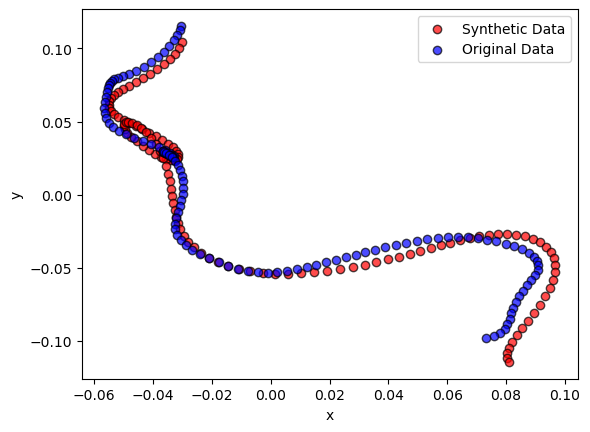

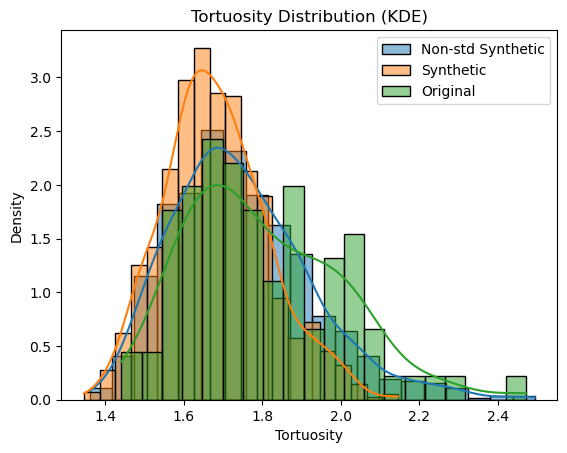

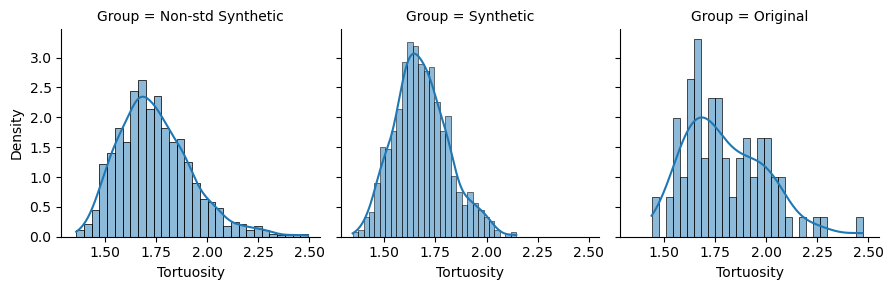

In [70]:
# 预处理数据
scaler = StandardScaler()
non_std_X = original_centerlines.reshape(curve_bs.shape[0], -1)
non_std_X_scaled = scaler.fit_transform(non_std_X)

# PCA 降维
non_std_PCA = PCA(n_components=10)
non_std_PCA_features = non_std_PCA.fit_transform(non_std_X_scaled)

# 计算 PCA 特征的均值和协方差
non_std_PCA_features_mean = np.mean(non_std_PCA_features, axis=0)
non_std_PCA_features_cov = np.cov(non_std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_non_std_features = np.random.multivariate_normal(non_std_PCA_features_mean, non_std_PCA_features_cov * 1.0, size=1000)

# 逆 PCA 变换
synthetic_non_std_X_scaled = non_std_PCA.inverse_transform(synthetic_non_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_non_std_X = synthetic_non_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_non_std_centerlines = synthetic_non_std_X.reshape(1000, 120, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_non_std_centerlines[0][:, 0], synthetic_non_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(original_centerlines[0][:, 0], original_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


# 计算 original_tortuosities
non_std_synthetic_tortuosity = []
for i in range(len(synthetic_non_std_centerlines)):
    non_std_synthetic_tortuosity.append(calculate_curve_length(synthetic_non_std_centerlines[i]) / np.linalg.norm(synthetic_non_std_centerlines[i][-1] - synthetic_non_std_centerlines[i][0]))
non_std_synthetic_tortuosity = np.array(non_std_synthetic_tortuosity)

# 设置相同的bins
bins = np.linspace(
    min(non_std_synthetic_tortuosity.min(), synthetic_tortuosity.min(), original_tortuosities.min()),
    max(non_std_synthetic_tortuosity.max(), synthetic_tortuosity.max(), original_tortuosities.max()),
    20
)

# 计算每组数据在每个bin的频数
counts1, _ = np.histogram(non_std_synthetic_tortuosity, bins=bins)
counts2, _ = np.histogram(synthetic_tortuosity, bins=bins)
counts3, _ = np.histogram(original_tortuosities, bins=bins)

# 设置柱状图的宽度
bar_width = (bins[1] - bins[0]) * 0.3

sns.histplot(non_std_synthetic_tortuosity, kde=True, bins=20, stat='density', label='Non-std Synthetic')
sns.histplot(synthetic_tortuosity, kde=True, bins=20, stat='density', label='Synthetic')
sns.histplot(original_tortuosities, kde=True, bins=20, stat='density', label='Original')

plt.xlabel("Tortuosity")
plt.ylabel("Density")
plt.title("Tortuosity Distribution (KDE)")
plt.legend()
plt.show()

df = pd.DataFrame({
    'Tortuosity': np.concatenate([non_std_synthetic_tortuosity, synthetic_tortuosity, original_tortuosities]),
    'Group': (['Non-std Synthetic'] * len(non_std_synthetic_tortuosity) +
              ['Synthetic'] * len(synthetic_tortuosity) +
              ['Original'] * len(original_tortuosities))
})

g = sns.FacetGrid(df, col="Group", sharex=True, sharey=True)
g.map(sns.histplot, "Tortuosity", bins=30, stat='density', kde=True)

plt.show()

